## Simple Fixation Map training (2 layers)
with clutter / whitening

In [1]:
figname = '../paper/fig_result'

In [2]:
%matplotlib inline

In [3]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import noise
import MotionClouds as mc

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [6]:
from LogGabor import LogGabor

In [7]:
#import SLIP for whitening and PIL for resizing
import SLIP
import PIL
whit = SLIP.Image(pe='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py')

## Noise stuff

In [8]:
def MotionCloudNoise(sf_0=0.125, B_sf=3., alpha = .5):
    mc.N_X, mc.N_Y, mc.N_frame = 128, 128, 1
    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    name = 'static'
    env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=B_sf, B_theta=np.inf, V_X=0., V_Y=0., B_V=0, alpha= alpha)
    
    z = mc.rectif(mc.random_cloud(env))
    z = z.reshape((mc.N_X, mc.N_Y))
    return z, env


### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

In [9]:
# TODO: passer les arguments par la ligne de commande
N_theta = 6
N_azimuth = 16
N_eccentricity = 10
N_phase = 2
N_X = 128
N_Y = 128
rho = 1.41
verbose = 1


#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [10]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=.8, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                #psi = i_azimuth * np.pi * 2 / N_azimuth
                psi = (i_azimuth + 1 * (i_eccentricity % 2)*.5) * np.pi * 2 / N_azimuth
                theta_ref = i_theta*np.pi/N_theta
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos(psi)
                y = N_Y/2 + r * np.sin(psi)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': theta_ref + psi, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel() #* ecc

    return retina


#### Full encoding

In [11]:
retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina.shape)

(6, 16, 10, 2, 16384)


In [12]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1920, 16384)


In [13]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1920)


#### Orientation invariant power encoding (colliculus??)

In [14]:
colliculus = (retina**2).sum(axis=(0, 3))
#colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(16, 10, 16384)


In [15]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(160, 16384)


In [16]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 160)


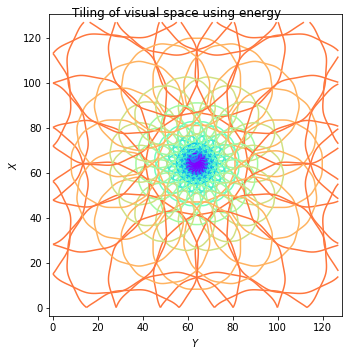

In [17]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

#### MNIST dataset read out

In [18]:
def get_data_loader(batch_size=100, train=True):
    data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/tmp/data',
                       train=train,     # def the dataset as training data
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0,), std=(1,))])),
                       batch_size=batch_size,
                       shuffle=True)
    return data_loader


In [19]:
loader = get_data_loader(batch_size=100, train = False)

AttributeError: 'Tensor' object has no attribute 'ndim'

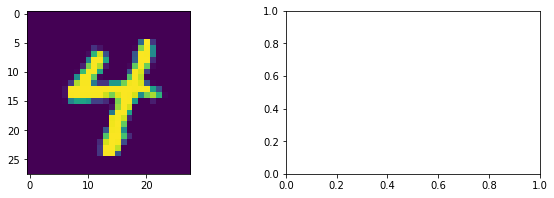

In [20]:
data, label = next(iter(loader))
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(data[0,0,:,:])
plt.subplot(122)
_ = plt.plot(data[0,0,:,:])

## Accuracy map

In [ ]:
path = "../data/MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

In [ ]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(accuracy_map)
plt.subplot(122)
_ = plt.plot(accuracy_map)

### From MNIST encoding

#### Input vectors encoding

In [ ]:
def mnist_fullfield(data, i_offset, j_offset, N_pic=128, CONTRAST=1., NOISE = 1., sf_0 = 0.1, B_sf = 0.1):
    N_stim = data.shape[0]
    center = (N_pic-N_stim)//2

    data_fullfield = (data.min().numpy()) * np.ones((N_pic, N_pic))
    data_fullfield[int(center+i_offset):int(center+N_stim+i_offset), int(center+j_offset):int(center+N_stim+j_offset)] = data

    # data normalization
    # data_fullfield -= data_fullfield.mean()
    # data_fullfield /= data_fullfield.std()
    # data_fullfield *= std
    # data_fullfield += mean
    data_fullfield = (data_fullfield - data_fullfield.min())/(data_fullfield.max() - data_fullfield.min())
    data_fullfield *= CONTRAST
    data_fullfield += 0.5

    if NOISE>0.:
        im_noise, _ = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf)
        im_noise = NOISE *  im_noise
        data_fullfield += im_noise #randomized_perlin_noise() #
        #indices_data = np.where(data_fullfield > data_fullfield.mean())
        #im_noise[indices_data] = data_fullfield[indices_data]
        #data_fullfield = im_noise
    
    whit.set_size((N_pic,N_pic))
    data_fullfield = whit.whitening(data_fullfield)

    data_retina = retina_vector @ np.ravel(data_fullfield)
    
    tensor_retina = data_retina.reshape(N_theta, N_azimuth, N_eccentricity, N_phase)
    slice1 = tensor_retina[N_theta - 1,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
    slice2 = tensor_retina[0,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
    tensor_retina = np.concatenate ((slice1, tensor_retina, slice2), axis = 0)
    tensor_retina = np.transpose(tensor_retina,(3,0,1,2))

    return data_retina, tensor_retina, data_fullfield

In [ ]:
def accuracy_fullfield(accuracy_map, i_offset, j_offset, N_pic=128):
    N_stim = accuracy_map.shape[0]
    center = (N_pic-N_stim)//2

    accuracy_fullfield = 0.1 * np.ones((N_pic, N_pic))
    accuracy_fullfield[int(center+i_offset):int(center+N_stim+i_offset),
                 int(center+j_offset):int(center+N_stim+j_offset)] = accuracy_map

    accuracy_colliculus = colliculus_vector @ np.ravel(accuracy_fullfield)
    #accuracy_colliculus = test_vector @ np.ravel(accuracy_fullfield)

    return accuracy_colliculus, accuracy_fullfield

#### Utilitaires

In [ ]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

# Hyperparameters

In [ ]:
minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-4 #1e-3  #0.05

OFFSET_STD = 15 #
OFFSET_MAX = 30 #
NOISE = 1 #0 #
CONTRAST = 0.3 #1 #
sf_0 = 0.2
B_sf = 0.3

### Test

In [ ]:
if True:
    i = 4
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_vector, _, image = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                    sf_0 = sf_0, B_sf = B_sf)
    #plt.imshow(input_test)
    plt.figure(figsize = (20,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    f = plt.plot(input_vector)
    plt.subplot(133)
    im = retina_inverse @ input_vector
    plt.imshow(im.reshape(128, 128))


In [ ]:
if True:
    i = 4
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    coll_fixmap, image = accuracy_fullfield(accuracy_map, i_offset, j_offset)
    #plt.imshow(input_test)
    plt.figure(figsize = (20,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    f = plt.plot(coll_fixmap)
    plt.subplot(133)
    im = colliculus_inverse @ coll_fixmap
    plt.imshow(im.reshape(128, 128))
    print(max(coll_fixmap))
    print(max(im))
    


#### Torch stuff

In [ ]:
do_cuda = False # torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [ ]:
train_loader = get_data_loader(batch_size=minibatch_size, train = True)
test_loader = get_data_loader(batch_size=1000, train = False)

# Network

In [ ]:
BIAS_CONV = True
BIAS_DECONV = True #True

class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #self.bn1= torch.nn.Linear(N_theta*N_azimuth*N_eccentricity*N_phase, 200, bias = BIAS_DECONV)
        self.bn1= torch.nn.Linear(N_theta*N_azimuth*N_eccentricity*N_phase, 1000, bias = BIAS_DECONV)
        #self.bn2 = torch.nn.Linear(200, 80, bias = BIAS_DECONV)
        self.bn2 = torch.nn.Linear(1000, 1000, bias = BIAS_DECONV)
        #self.bn3 = torch.nn.Linear(80, N_azimuth*N_eccentricity, bias = BIAS_DECONV)
        self.bn3 = torch.nn.Linear(1000, N_azimuth*N_eccentricity, bias = BIAS_DECONV)
                
    def forward(self, image):
       
        h_bn1 = F.relu(self.bn1(image))               
        h_bn2 = F.relu(self.bn2(h_bn1))
        h_bn2_drop = F.dropout(h_bn2, p = .5) 
        u = self.bn3(h_bn2_drop)
        
        return u


In [ ]:
net = Net()

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
loss_func = torch.nn.BCEWithLogitsLoss() #torch.nn.CrossEntropyLoss()

In [ ]:
#### Training

In [ ]:
def accuracy_gain(prediction, fixmap_data, batch_size, full_fixmap = None):
    #ndices_max = np.zeros(batch_size, dtype = 'int')
    acc = [] #np.zeros(batch_size)
    
    for i in range(batch_size):
        fixmap_coll =  fixmap_data[i,:].data.numpy()
        pred_coll = F.sigmoid(prediction[i,:]).data.numpy()
        
        indice_max_coll = np.where(pred_coll == max(pred_coll))[0][0]
        acc_coll = fixmap_coll[indice_max_coll]
        
        '''masque = 0.1 + np.zeros(fixmap_coll.shape)
        masque[indice_max_coll] = 1'''
        
        test = pred_coll.reshape((N_azimuth, N_eccentricity))
        indices_ij = np.where(test == max(test.flatten()))
        azimuth = indices_ij[0][0]
        eccentricity = indices_ij[1][0]
        full_masque = colliculus[azimuth,eccentricity,:] #> 0.0003
        
        
        #print(indices_ij)
        '''j_max = indices_ij[1][0]
        if j_max > 1:
            test[:,:int(j_max*2/3)] = 0.1 
        pred_coll_test = test.flatten()'''
        
        if full_fixmap is not None:
            full_ref = full_fixmap[i,:]
            #print('OK')
        else:
            full_ref = colliculus_inverse @ fixmap_coll.flatten()
            
        full_pred = colliculus_inverse @ pred_coll.flatten()
        #full_masque = colliculus_inverse @ masque.flatten()
        #masque[np.where(masque < 0.11)] = 0
#        full_pred *= full_masque
        full_pred = full_masque
        #full_pred = colliculus_inverse @ pred_coll_test.flatten()
        
        indice_max_full = np.where(full_pred == max(full_pred))[0][0]
        #print(indice_max_full)
        acc_full = full_ref[indice_max_full] 
                
        #acc[i] = max(acc_full, acc_coll)
        if acc_full > acc_coll:
            acc += [acc_full]
            
        #acc[i] = 0.1 + (acc[i] - 0.1) * 2.25
    #print(indices_max)
    if len(acc) > 0:
        acc_mean = np.mean(acc) #fixmap_data.data.numpy()[:,indices_max])
    else:
        acc_mean = acc_coll
    #acc = np.mean(fixmap_data[:,indices_max])
    return acc_mean, acc

In [ ]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = 1, \
          offset_std=OFFSET_STD, \
          offset_max=OFFSET_MAX, \
          verbose=1, \
          CONTRAST=CONTRAST,
          NOISE = NOISE,
          sf_0 = sf_0, 
          B_sf = B_sf):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        retina_data = np.zeros((minibatch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
        fixmap_data = np.zeros((minibatch_size, N_azimuth * N_eccentricity))

        for i in range(minibatch_size):
            i_offset = minmax(np.random.randn() * offset_std, offset_max)
            j_offset = minmax(np.random.randn() * offset_std, offset_max)
            retina_data[i, :], _, _  = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                                        CONTRAST = CONTRAST, NOISE = NOISE,
                                                        sf_0 = sf_0, B_sf = B_sf) 
            fixmap_data[i,:], _ = accuracy_fullfield(accuracy_map, i_offset, j_offset)
            

        retina_data = Variable(torch.FloatTensor(retina_data))
        fixmap_data = Variable(torch.FloatTensor(fixmap_data))
        
        prediction = net(retina_data)
        loss = loss_func(prediction, fixmap_data)
        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            #indices_max = np.zeros(minibatch_size, dtype = 'int')
            #for i in range(minibatch_size):
            #    indices_max[i] = np.where(prediction[i,:] == max(prediction[i,:]))[0][0]
            #acc = np.mean(fixmap_data.data.numpy()[:,indices_max])
            acc, _ = accuracy_gain(prediction, fixmap_data, minibatch_size)
            print('[%d/%d] Loss: %.3f Acc : %.3f'%(batch_idx*minibatch_size, len(train_loader.dataset),loss.data.numpy(), acc))
            f = open('../data/2019-03-06-Necc-8.txt', 'a')
            f.write('%.5f\t%.5f'%(loss, acc))    
            f.close()
    return net


In [ ]:
def test(net, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity, offset_std=OFFSET_STD, offset_max=OFFSET_MAX, 
         CONTRAST=CONTRAST, NOISE = NOISE,
         sf_0 = sf_0, 
         B_sf = B_sf):
    #for batch_idx, (data, label) in enumerate(test_loader):
    data, label = next(iter(test_loader))
    batch_size = label.shape[0]

    retina_data = np.zeros((batch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
    fixmap_data = np.zeros((batch_size, N_azimuth * N_eccentricity))

    for i in range(batch_size):
        i_offset = minmax(np.random.randn() * offset_std, offset_max)
        j_offset = minmax(np.random.randn() * offset_std, offset_max)
        retina_data[i, :], _, _  = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                                    sf_0 = sf_0, B_sf = B_sf)
        fixmap_data[i, :], _ = accuracy_fullfield(accuracy_map, i_offset, j_offset)


    retina_data = Variable(torch.FloatTensor(retina_data))
    fixmap_data = Variable(torch.FloatTensor(fixmap_data))
    
    with torch.no_grad():
        output = net(retina_data) #.data.numpy()
        #indices_max = np.zeros(batch_size, dtype = 'int')
        #for i in range(batch_size):
        #    indices_max[i] = np.where(output[i,:] == max(output[i,:]))[0][0]
        #acc = np.mean(fixmap_data.data.numpy()[:,indices_max])
        #acc = 0.1 + (acc - 0.1) * 2.5
        acc, _ = accuracy_gain(output, fixmap_data, batch_size)

    return acc


## Anywhere target, with noise

#### Additive noise + whitening

In [ ]:
FIC_NAME = "../data/2019-02-15-anywhere-additive-noise-white-1000-Necc-10"
if not(os.path.isfile(FIC_NAME + '.npy'):
    for epoch in range(10):
        train(net, minibatch_size)
        loss = test(net)
        print('Test set: Final Loss: %.3f'%loss) 
    torch.save(net, FIC_NAME + '.npy')
else:
    net = torch.load(FIC_NAME + '.npy')       

# Visualisation

In [ ]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=OFFSET_STD
offset_max=OFFSET_MAX

test_batch_size = 20
test_loader = get_data_loader(batch_size=test_batch_size, train = False)

data, label = next(iter(test_loader))
input_n = np.zeros((test_batch_size, 1, vsize))
a_data_n = np.zeros((test_batch_size, 1, asize))
full_fixmap_n = np.zeros((test_batch_size, 128, 128))
        # target = np.zeros((minibatch_size, asize))

for idx in range(test_batch_size):
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_n[idx, 0, :], _, _ = mnist_fullfield(data[idx, 0, :, :], i_offset, j_offset, 
                                            CONTRAST = CONTRAST, NOISE = NOISE,
                                            sf_0 = sf_0, B_sf = B_sf)
    a_data_n[idx, 0, :], full_fixmap_n[idx, :, :] = accuracy_fullfield(accuracy_map, i_offset, j_offset)

In [ ]:
delta = 1/N_azimuth
log_r, theta = np.meshgrid(np.linspace(0, 1, N_eccentricity + 1), np.linspace(-np.pi*(.5 + delta), np.pi*(1.5 - delta), N_azimuth + 1))
for idx in range(test_batch_size):
    im = retina_inverse @ input_n[idx,0,:]
    plt.figure(figsize = (15, 5))
    plt.subplot(161)
    plt.plot(input_n[idx,0,:])
    plt.subplot(162)
    plt.imshow(im.reshape(128, 128))
    plt.plot(63.5, 63.5, 'r+')
    plt.title(idx)
    plt.subplot(163)
    plt.plot(a_data_n[idx,0,:])    
    col = colliculus_inverse @ a_data_n[idx,0,:]
    ax = plt.subplot(164, projection='polar')
    vec_t = Variable(torch.FloatTensor(a_data_n[idx,0,:]))
    vec_t = vec_t.reshape((1,N_azimuth * N_eccentricity))
    ax.pcolor(theta, log_r, vec_t.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(col.reshape(128, 128))
    in_t = Variable(torch.FloatTensor(input_n[idx,0,:]))
    out_t = net(in_t)
    out_sig = F.sigmoid(out_t).detach().numpy()
    out_t = out_t.reshape((1,N_azimuth * N_eccentricity))
    #acc, _ = accuracy_gain(out_t.reshape(1,N_azimuth * N_eccentricity), vec_t.reshape(1,N_azimuth * N_eccentricity), 1)
    acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
    plt.subplot(165)
    plt.plot(out_sig)    
    plt.title(acc)
    view = colliculus_inverse @ out_sig.flatten()
    ax = plt.subplot(166, projection='polar')
    ax.pcolor(theta, log_r, out_sig.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(view.reshape(128, 128))
                                 

In [ ]:
if True:
    i = 0
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_vector, _, image = mnist_fullfield(data[i, 0, :, :], i_offset, j_offset, 
                                    CONTRAST = CONTRAST, NOISE = NOISE,
                                    sf_0 = sf_0, B_sf = B_sf)
    coll_fixmap, image = accuracy_fullfield(accuracy_map, i_offset, j_offset)
    #plt.imshow(input_test)
    in_ = Variable(torch.FloatTensor(input_vector))
    out = net(in_)
    
    plt.figure(figsize = (20,6))

    plt.subplot(151)
    plt.imshow(image)

    plt.subplot(152)
    f = plt.plot(coll_fixmap)
    f = plt.plot(F.sigmoid(out.data))

    plt.subplot(153)
    im = colliculus_inverse @ coll_fixmap
    plt.imshow(im.reshape(128, 128))
    print(max(coll_fixmap))
    print(max(im))

    plt.subplot(154)
    im_pred = colliculus_inverse @ F.sigmoid(out).data.numpy().flatten()
    plt.imshow(im_pred.reshape(128, 128))
    ind_pred = np.where(im_pred == max(im_pred))
    print(im[ind_pred])

    plt.subplot(155)
    test = F.sigmoid(out).data.numpy().reshape((N_azimuth, N_eccentricity))
    indices_ij = np.where(test == max(test.flatten()))
    azimuth = indices_ij[0][0]
    eccentricity = indices_ij[1][0]
    full_masque = colliculus[azimuth,eccentricity,:].reshape(128, 128)
    plt.imshow(im_pred.reshape(128, 128) * full_masque)
    


In [ ]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=OFFSET_STD
offset_max=OFFSET_MAX

test_batch_size = 1000

mem_acc_log = []
mem_acc_data_log = []
mem_ref_log = []
mem_ref_data_log = []

ecc_max=.8

for i_eccentricity in range(9):
    ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc
    print(r)

    test_loader_2 = get_data_loader(batch_size=test_batch_size, train = False)

    data, label = next(iter(test_loader_2))
    input_n = np.zeros((test_batch_size, 1, vsize))
    a_data = np.zeros((test_batch_size, asize))
    full_fixmap_n = np.zeros((test_batch_size, 128 * 128))
    # target = np.zeros((minibatch_size, asize))
        
    ref_data = np.zeros(test_batch_size)

    for idx in range(test_batch_size):
        theta = np.random.rand() * 2 * np.pi
        i_offset = int(r * np.cos(theta))
        j_offset = int(r * np.sin(theta))
        #i_offset = i #minmax(np.random.randn() * offset_std, offset_max)
        #j_offset = 0 #minmax(np.random.randn() * offset_std, offset_max)
        input_n[idx, 0, :], _, _ = mnist_fullfield(data[idx, 0, :, :], i_offset, j_offset, 
                                                CONTRAST = CONTRAST, NOISE = NOISE,
                                                sf_0 = sf_0, B_sf = B_sf)
        a_data[idx, :], tmp = accuracy_fullfield(accuracy_map, i_offset, j_offset)
        full_fixmap_n[idx,:] = tmp.flatten()
        if r < 28:
            ref_data[idx] = accuracy_map[27 + i_offset, 27 + j_offset]
        else:
            ref_data[idx] = 0.1        
        
        
    in_t = Variable(torch.FloatTensor(input_n))
    out_t = net(in_t)
    a_data_t = Variable(torch.FloatTensor(a_data))
    #out_sig = F.sigmoid(out).detach().numpy()
    acc, acc_data = accuracy_gain(out_t, a_data_t, test_batch_size, full_fixmap=full_fixmap_n)
    mem_acc_log += [acc]
    mem_acc_data_log += [acc_data]
    
    mem_ref_log += [np.mean(ref_data)]
    

In [ ]:
idx = 3

plt.figure(figsize = (21,6))
plt.subplot(1,4,1)
im = retina_inverse @ input_n[idx,0,:]
plt.imshow(im.reshape(128, 128))
plt.plot(64.5, 64.5, 'r+', markersize = 14, mew=3)
plt.axis('off')
plt.title('Input', fontsize = 14)

ax = plt.subplot(2,8,3, projection='polar')
vec_t = Variable(torch.FloatTensor(a_data_n[idx,0,:]))
vec_t = vec_t.reshape((1,N_azimuth * N_eccentricity))
ax.pcolor(theta, log_r, vec_t.reshape((N_azimuth, N_eccentricity)))
ax.grid('off')
#ax.set_rgrids('off')
plt.title('True', fontsize = 14)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = plt.subplot(2,8,11, projection='polar')
in_t = Variable(torch.FloatTensor(input_n[idx,0,:]))
out_t = net(in_t)
out_sig = F.sigmoid(out_t).detach().numpy()
ax.pcolor(theta, log_r, out_sig.reshape((N_azimuth, N_eccentricity)))
plt.title('Predicted', fontsize = 14)
ax.set_yticklabels([])
ax.set_xticklabels([])

test = out_sig.reshape((N_azimuth, N_eccentricity))
indices_ij = np.where(test == max(test.flatten()))
azimuth = indices_ij[0][0]
eccentricity = indices_ij[1][0]
full_masque = colliculus[azimuth,eccentricity,:]
indice_move = np.where(full_masque == max(full_masque))
i_move = indice_move[0][0] // 128 - 64
j_move = indice_move[0][0] % 128 - 64
print(i_move, j_move)

plt.subplot(1,8,(4,5))
im = retina_inverse @ input_n[idx,0,:]
plt.imshow(im.reshape(128, 128))
plt.plot(64.5, 64.5, 'r+', markersize = 14, mew=3)
plt.arrow(64.5, 64.5, j_move, i_move, color = 'red', linewidth = 3, head_width=3, head_length=3)

plt.axis('off')
vec_t = vec_t.reshape((1,N_azimuth * N_eccentricity))
out_t = out_t.reshape((1,N_azimuth * N_eccentricity))
acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
plt.title('Final accuracy : ' + str(acc), fontsize = 14)

plt.subplot(1,32,(23, 32))
plt.bar(range(1,10), mem_acc_log, alpha = .5, label = 'One saccade')
plt.bar(range(1,10), mem_ref_log, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
plt.plot([0.5,9.5], [0.1, 0.1], ':', label = 'Baseline')
plt.legend()
plt.title('Class accuracy', fontsize = 14)
plt.xlabel('Target eccentricity (scale)', fontsize = 12)
plt.xticks(range(1,10))
plt.ylim([0,1])
plt.savefig(figname)


In [ ]:
std_data_log = np.zeros(9)
for i in range(9):
    std_data_log[i] = np.std(mem_acc_data_log[i])

In [ ]:
mem_acc_data_log[8]

In [ ]:
plt.fill_between(range(1,10), mem_acc_log + std_data_log, mem_acc_log - std_data_log, alpha = .3)
plt.plot(range(1,10), mem_acc_log)
plt.plot(range(1,10), mem_ref_log) #accuracy_map[27,27:55])

In [ ]:
plt.bar(range(1,10), mem_ref_log, alpha = .5) #accuracy_map[27,27:55])

f = plt.boxplot(mem_acc_data_log, showfliers=False)
#f = plt.plot(range(1,10), mem__log) #accuracy_map[27,27:55])



In [ ]:
mem_acc

In [ ]:
mem_acc

In [ ]:
'''im_coll = colliculus[0,0,:].reshape((128,128)) +\
        colliculus[1,0,:].reshape((128,128)) +\
        colliculus[2,0,:].reshape((128,128)) +\
        colliculus[3,0,:].reshape((128,128)) +\
        colliculus[4,0,:].reshape((128,128)) +\
        colliculus[5,0,:].reshape((128,128)) +\
        colliculus[6,0,:].reshape((128,128)) +\
        colliculus[7,0,:].reshape((128,128))'''
im_coll = colliculus[4,0,:].reshape((128,128))
plt.imshow(im_coll)
plt.figure()
f = plt.plot(im_coll)
print(sum(im_coll.flatten()))
f = plt.plot(np.arange(0,55) - 27 + 64, accuracy_map[:,:])

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
im_sum = colliculus[0,0,:].reshape((128,128)) +\
           colliculus[0,1,:].reshape((128,128)) +\
           colliculus[0,3,:].reshape((128,128)) +\
           colliculus[0,4,:].reshape((128,128)) +\
           colliculus[0,5,:].reshape((128,128)) +\
           colliculus[0,6,:].reshape((128,128)) +\
           colliculus[0,7,:].reshape((128,128)) +\
           colliculus[0,8,:].reshape((128,128))
f = plt.plot(im_sum)

In [ ]:
plt.imshow(colliculus[0,5,:].reshape(128,128) > 0.0003)

In [ ]:
accuracy_map.shape